In [ ]:
from typing import Annotated, List, Literal, Optional
from pydantic import BaseModel, Field
from operator import add
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.graph.state import CompiledStateGraph
from IPython.display import Image, display
# HuggingFace
from langchain_huggingface.embeddings import HuggingFaceEndpointEmbeddings
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
# Prompts
from langchain.prompts import PromptTemplate
from langchain_core.messages import BaseMessage
from langchain_core.tools import tool
# Others
import os
from dotenv import load_dotenv
# # LangSmith
# import uuid
# from langchain_core.tracers.context import collect_runs
# from langchain_core.tracers.langchain import wait_for_all_tracers
# from langsmith import Client
# from langchain.callbacks.tracers import LangChainTracer

In [2]:
# Understanding Pydantic and Typing
# https://typing.python.org/en/latest/spec/annotations.html
# https://docs.pydantic.dev/latest/
# https://medium.com/@moraneus/exploring-the-power-of-pythons-typing-library-ff32cec44981
# https://coderivers.org/blog/typingannotated-python/
# https://chatgpt.com/share/68644926-ccfc-800a-b668-4752077e3a29

In [3]:
# Provide the filename as a string
load_dotenv('../.env')

True

## **Define State**

In [4]:
class ResearchArticle(BaseModel):
    text: str
    title:str
    category: str

class ResearchArticleState(BaseModel):
    """
    Represents the evolving state of the article bot.
    """
    article: Annotated[List[ResearchArticle], add] = []
    articles_choice: Literal["n", "c", "q"] = "n"
    category: str = "nlp"
    title:str = "Solving the myth and facts of child development with nlp"
    quit: bool = False

In [5]:
class AgenticResearchArticleState(ResearchArticleState):
    latest_article: str = ""
    approved: bool = False
    retry_count:int = 0

## **Utilities**

In [6]:
def get_user_input(prompt:str)-> str:
    prompt_input = input(prompt)
    prompt_input = "".join(prompt_input).strip().lower()
    return prompt_input

def print_article(article:ResearchArticle):
    """
    Print article with nice formatting
    """
    print(f"\nCATEGORY: {article.category.upper()}\n")
    print(f"\n{article.title}\n")
    print(f"\n{article.text}\n")
    print("="* 60)

def print_menu_header(category:str, total_articles:int):
    """
    Print a compact menu header
    """
    print(f"🎭 Menu | Category: {category.upper()} | Articles: {total_articles}")
    print("-" * 50)

## **LLMS**

In [7]:
# Provide the filename as a string
load_dotenv('.env')


# loadding Huggingface token
HUGGINGFACEHUB_API_TOKEN = os.getenv("HUGGINGFACEHUB_API_TOKEN")

# models 
repo_id_writer = "mistralai/Mistral-7B-Instruct-v0.3"
repo_id_critic = "mistralai/Mistral-7B-Instruct-v0.3"
# repo_id_critic = "mistralai/Mistral-Small-24B-Instruct-2501"


# model parameters
model_kwargs_writer = {
    "max_new_tokens": 200, # Maximum tokens to generate
    "max_length": 100, # Maximum length of input + output
    "temperature": 0.8, # Controls randomness of output
    "timeout": 6000,
    # "task":'conversational'
}

# LLM set up
llm_writer = HuggingFaceEndpoint(
    repo_id=repo_id_writer,
    huggingfacehub_api_token = HUGGINGFACEHUB_API_TOKEN,
    **model_kwargs_writer
    # you specify the task or not
    # You can also specify the task in the model_kwargs or within here
    # task = 'conversational',
)
# model parameters
model_kwargs_critic = {
    "max_new_tokens": 5, # Maximum tokens to generate
    # "max_length": 4000, # Maximum length of input + output
    "temperature": 0.1, # Controls randomness of output
    "timeout": 6000,
    # "task":'conversational'
}

# LLM set up
llm_critic = HuggingFaceEndpoint(
    repo_id=repo_id_critic,
    huggingfacehub_api_token = HUGGINGFACEHUB_API_TOKEN,
    **model_kwargs_critic
    # you specify the task or not
    # You can also specify the task in the model_kwargs or within here
    # task = 'conversational',
)

chat_model_writer = ChatHuggingFace(llm=llm_writer)
chat_model_critic = ChatHuggingFace(llm=llm_critic)

WARNING! max_length is not default parameter.
                    max_length was transferred to model_kwargs.
                    Please make sure that max_length is what you intended.


## **Prompts**

In [8]:
# Writer prompt
WRITER_PROMPT = """
You are the best captivating research abstract generator 
with 20 years of experience 
who can write the most interesting research abstracts.\n
When given a category and title, be as detailed and concise as possible.\n\n\n
Here are examples
======================================================
category: nlp
Title:The Next Frontier in Natural Language Processing

Abstract
Natural Language Processing (NLP) has evolved from rule-based text manipulation to enabling human-like interactions across billions of devices. While transformers like BERT and GPT revolutionized text understanding, the next frontier lies in grounding language in real-world context, emotion, and dynamic memory. This article explores the state-of-the-art in NLP, its challenges, and the emerging paradigms shaping its future—from multimodal intelligence to reasoning-aware models.
======================================================
\n\n\n
Category: {category}
Title: {title}
Abstract: 
"""
# Critic prompt
CRITIC_PROMPT = """
Daniel the greatest critic and editor of research articles.\n
You evaluate all research article blog post to see if they are structured or not.
You reponse only by saying YES or NO.\n\n\n
======================================================
Here are examples
category: nlp
Title: Eyes of the Machine: The Expanding Horizon of Computer Vision
Abstract:
Computer Vision, once limited to edge detection and barcode scanning, now powers autonomous vehicles, medical diagnosis, and generative art. From convolutional neural networks (CNNs) to vision-language transformers and neuromorphic sensors, the field is undergoing a seismic transformation. This article explores the evolving landscape of CV, current breakthroughs, limitations, and the emerging frontier of visual intelligence.
Response: YES
======================================================
\n\n\n
Abstract: {abstract}
RESPONSE: 
"""

In [9]:
writer_input_variable = ['category','title']
writer_prompt = PromptTemplate(template=WRITER_PROMPT,
                              input_variables=writer_input_variable)


critic_prompt_variable = ['abstract']
critic_prompt = PromptTemplate(
    template=CRITIC_PROMPT,input_variables=critic_prompt_variable
)

## **Define Nodes**

In [ ]:
def make_writer_node(llm):
    def writer_node(state: AgenticResearchArticleState) -> dict:
        chain = writer_prompt | llm
        response = chain.invoke({"category": state.category, "title": state.title})
        content = response.content.strip().lower()
        return {"latest_article": content}
    return writer_node

In [ ]:
# critic-node
def make_critic_node(llm):
    def critic_node(state:AgenticResearchArticleState)-> dict:
        critic = critic_prompt | llm
        decision = critic.invoke({"abstract": state.latest_article})
        decision = decision.content.strip().lower()
        approved = "yes" in decision
        return {
            "approved":approved,
            "retry_count":state.retry_count + 1
        }
    return critic_node

In [12]:
def show_final_article(state:AgenticResearchArticleState) -> dict:
    article = ResearchArticle(
        text=state.latest_article,
        category=state.category,
        title=state.title
    )
    print_article(article)
    return {
        "article":[article],
        "retry_count": 0,
        'approved': False
    }

In [13]:
def writer_critic_router(state: AgenticResearchArticleState) -> str:
    if state.approved or state.retry_count >= 20:
        return "show_final_article"
    return "writer"

In [14]:
def show_menu(state: ResearchArticleState) -> dict:
    print_menu_header(state.category, len(state.article))
    print("Pick an option")
    user_input = get_user_input(
        "[n] 🎭 Next Article \n[c] 📂 Change Category\n[q] 🚪 Quit\nUser Input: "
    )

    while user_input not in ["n", "c", "q"]:
        print("❌ Invalid input. Please try again.")
        user_input = get_user_input(
            "[n] 🎭 Next Article  [c] 📂 Change Category  [q] 🚪 Quit\n    User Input: "
        )

    result = {"articles_choice": user_input}

    # Always prompt for title when 'n' is chosen
    if user_input == "n":
        title = input("\nEnter a title for the new article:\n\nTITLE: ")
        result["title"] = title.strip()

    return result



# # Original
# def show_menu(state:ResearchArticleState) -> dict:
#     print_menu_header(state.category,len(state.article))
#     print("Pick an option")
#     user_input = get_user_input(
#         "[n] 🎭 Next Article \n[c] 📂 Change Category\n[q] 🚪 Quit\nUser Input: "
#     )

#     while user_input not in ["n", "c", "q"]:
#         print("❌ Invalid input. Please try again.")
#         user_input = get_user_input(
#             "[n] 🎭 Next Article  [c] 📂 Change Category  [q] 🚪 Quit\n    User Input: "
#         )
#     return {"articles_choice": user_input}

In [15]:
def update_category(state: AgenticResearchArticleState) -> dict:
    categories = ["nlp", 
                  "computer_vision", 
                  "gen_ai"]
    print("CATEGORY SELECTION")
    print("=" * 60)

    for i, cat in enumerate(categories):
        print(f"    {i}. {cat.upper()}")

    print("=" * 60)

    try:
        selection = int(input("    Enter category number: ").strip())
        # title = input("What is your title? ")
        if 0 <= selection < len(categories):
            selected_category = categories[selection]
            print(f"    ✅ Category changed to: {selected_category.upper()}")
            return {
                "category": selected_category,
                # "title":title
                }
        else:
            print("    ❌ Invalid choice. Keeping current category.")
            return {}
    except ValueError:
        print("    ❌ Please enter a valid number. Keeping current category.")
        return {}

In [16]:
def exit_bot(state:ResearchArticleState) -> dict:
    print("\n" + "🚪" + "=" * 58 + "🚪")
    print("    GOODBYE!")
    print("=" * 60)
    return {"quit": True}

In [17]:
def route_choice(state:ResearchArticleState)-> str:
    """
    Router function to determine the next node based on user choice.
    Keys must match the target node names.
    """
    if state.articles_choice == "n":
        return "fetch_article"
    elif state.articles_choice == "c":
        return "update_category"
    elif state.articles_choice == "q":
        return "exit_bot"
    else:
        return "exit_bot"

## **Building the Graph**

In [18]:
def build_joke_graph(writer_llm, critic_llm) -> CompiledStateGraph:
    workflow = StateGraph(AgenticResearchArticleState)

    # Register nodes
    workflow.add_node("show_menu",show_menu)
    workflow.add_node("update_category",update_category)
    workflow.add_node("exit_bot",exit_bot)
    workflow.add_node("writer", make_writer_node(writer_llm))
    workflow.add_node("critic", make_critic_node(critic_llm))
    workflow.add_node("show_final_article",show_final_article)

    # Set entry point
    workflow.set_entry_point("show_menu")
    
    # Routing Logic-1
    workflow.add_conditional_edges(
        "show_menu",
        route_choice,
        {
            "fetch_article": "writer",
            "update_category": "update_category",
            "exit_bot": "exit_bot",  
        },
    )

    # Define transitions
    workflow.add_edge("update_category", "show_menu")
    workflow.add_edge("writer", "critic")
    
    
    # Routing Logic-2
    workflow.add_conditional_edges(
        'critic',
        writer_critic_router,
        {
            "writer": 'writer',
            "show_final_article": "show_final_article",
        }
    )
    workflow.add_edge("show_final_article", "show_menu")
    workflow.add_edge("exit_bot", END)
    
    return workflow.compile()

## **Graph Visualisation**

In [19]:
def graph_visualiser(graph):
    try:
        display(Image(graph.get_graph().draw_mermaid_png()))
    except Exception as e:
        print(e)

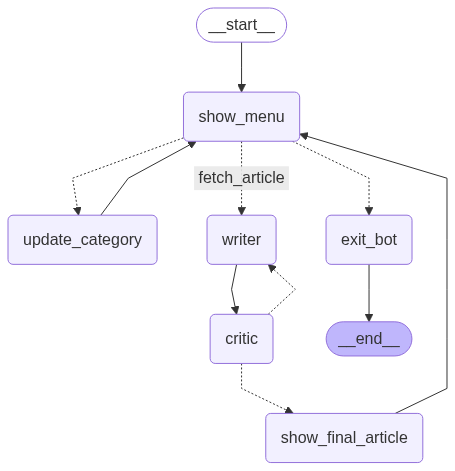

In [20]:
graph_visualiser(build_joke_graph(chat_model_writer,chat_model_critic))

## **Main Code**

In [21]:
def main():
    print("\n🎭 Starting article bot with writer–critic LLM loop...")
    graph = build_joke_graph(chat_model_writer,chat_model_critic)
    final_state = graph.invoke(
        AgenticResearchArticleState(category="nlp",
                                    title="Solving the myth and facts of child development with nlp"), 
        config={"recursion_limit": 1000}
    )
    print("\n✅ Done. Final Article Count:", len(final_state["article"]))

In [22]:
main()


🎭 Starting article bot with writer–critic LLM loop...
🎭 Menu | Category: NLP | Articles: 0
--------------------------------------------------
Pick an option

CATEGORY: NLP


"Solving the myth and facts of child development with nlp"


this study delves into the intersection of natural language processing (nlp) and child development, a promising yet under-explored field. by leveraging advanced nlp techniques, we aim to uncover hidden patterns and insights in vast amounts of data related to child development, debunking common myths and confirming established facts. our research focuses on sentiment analysis of parental interactions, identifying developmental milestones from speech patterns, and understanding the impact of environmental factors on language development. the findings of this study could potentially revolutionize our understanding of child development and pave the way for personalized educational interventions.

🎭 Menu | Category: NLP | Articles: 1
-------------------------